# Project 1

We can only see the balmer $\beta$ line in the stellar spectrograms. This is the line marked as $H_{\beta}$ in the spectrograms.
We can also see that each of the series share the same lower levels, and an alpha line from a series corresponds with a beta line of the series with one less lower level.

Since a molecule or an atom absorbes the photons and then scatters photons in different directions it is logical to think that the more we have of atoms in the same energy level the more photons are cattered and the line becomes stronger.

If we want to estimate the strength ratio we can start by looking at the Boltzmann law. We choose a temperature for the environment of the sample gas, and assume the gas consists of hydrogen atoms. We will also look at neutral stage atoms.
\begin{equation}
\frac{n_{1, s}}{N_{1}} = \frac{g_{1, s}}{U_{1}} e^{- \frac{X_{1, s}}{kT}}
\end{equation}
We then want to find the ratio of state $s_1$ and $s_2$.
\begin{equation}
\frac{n_{1, s_1} N_{1}}{n_{1, s_2} N_{1}} = \frac{g_{1, s_1} U_{1}}{g_{1, s_2} U_{1}} e^{- \frac{X_{1, s_1}}{kT}} e^{\frac{X_{1, s_2}}{kT}} \Rightarrow \frac{n_{1, s_1}}{n_{1, s_2}} = \frac{g_{1, s_1}}{g_{1, s_2}} e^{- \frac{X_{1, s_1} - X_{1, s_2}}{kT}}
\end{equation}
If we look at the hydrogen atom, the statistical weight is given by
\begin{equation}
g_{1, s} = 2s^2
\end{equation}
and the excitation energy
\begin{equation}
X_{1, s} = 13.598 \left( 1 - \frac{1}{s^2} \right) [eV]
\end{equation}
setting these expressios into the ratio expression, we get
\begin{equation}
\frac{n_{1, s_1}}{n_{1, s_2}} = \frac{s_1}{s_2} e^{\frac{2C (s_2^2 - s_1^2)}{s_1^2 s_2^2 k T}}
\end{equation}
We can make a simple python scrips for this and calculate this ratio for state 1, 2, 3 and 4.

In [7]:
from astropy.units import electronvolt
from astropy.constants import k_B
from numpy import exp
def ratio(T, s1, s2):
    C = 13.598 * electronvolt
    return s1 ** 2 / (s2 ** 2) * exp(2 * C * (s2 ** 2 - s1 ** 2) / (s1 ** 2 * s2 ** 2 * k_B * T))

Then we can use this function to calculate the ratio between all the four series, Lymann, Balmer, Paschen and Brackett.

In [9]:
from astropy.units import K
T = 5000 * K
print("n_1 / n_2 = ", ratio(T, 1, 2))
print("n_1 / n_3 = ", ratio(T, 1, 3))
print("n_1 / n_4 = ", ratio(T, 1, 4))
print("n_2 / n_3 = ", ratio(T, 2, 3))
print("n_2 / n_4 = ", ratio(T, 2, 4))
print("n_3 / n_4 = ", ratio(T, 3, 4))

n_1 / n_2 =  9.061730416756841e+19
n_1 / n_3 =  2.584050823417163e+23
n_1 / n_4 =  3.125855723481328e+24
n_2 / n_3 =  2851.608583101036
n_2 / n_4 =  34495.13039696057
n_3 / n_4 =  12.096726949618077


We assume a linear relation between the population dencity and the strenght of the corresponding lines. Thus the population density ratio is equal to the strength ratio.

The easies way to understant the difference between the Boltzmann and Saha distribution for rising temperature, is to plot the two and see how the distributions evolve.
We choose to just plot the general form that evolves with temperature and choose the forms
\begin{equation}
y_B = A e^{-B / T}
\end{equation}
\begin{equation}
y_S = C T^{3 / 2} e^{- D / T}
\end{equation}

We will also choose the values $A = 50$ and $B = C = D = 2$. Already here we can see that they should evolve differently since $y_B$ only has the exponential part, while $y_S$ also has a linear term to the power of three halvs.

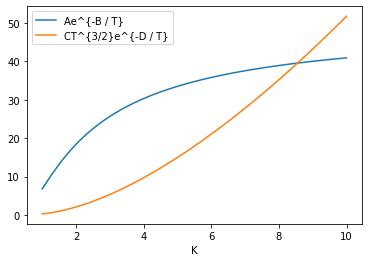

In [22]:
from numpy import linspace, exp
from matplotlib.pyplot import plot, xlabel, legend, show
T = linspace(1, 10, 100)
A = 50
B = 2
C = 2
D = 2
yB = A * exp(- B / T)
yS = C * T ** (3/2) * exp(-D / T)

plot(T, yB, T, yS)
xlabel("K")
legend(["Ae^{-B / T}", "CT^{3/2}e^{-D / T}"])
show()

Here we see that the Boltzmann distribution converges towards a finite point, while the Saha distribution rises to infinity. This is as already menshend because of the extra term in the Saha distribution.